In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gower
import umap

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import chi2_contingency


pd.set_option('future.no_silent_downcasting', True)

In [2]:
!pip install --upgrade scikit-learn umap-learn
import sklearn
print("Versión cargada:", sklearn.__version__)

Versión cargada: 1.7.2


In [3]:
# ==========================================
# 1. CARGA DE DATOS
# ==========================================
# ruta pablo
ruta = "data_adolescentes/adolescentes_ensanut2023_w_n.csv"
# ruta dani
# ruta = "/Users/danielarenee/Desktop/MD_proyecto_final/data_adolescentes/adolescentes_ensanut2023_w_n.csv"
data = pd.read_csv(ruta, delimiter=";")

In [4]:
# ==========================================
# 2. CREACIÓN DE VARIABLE TARGET
# ==========================================

variables_depresion = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f', 'd0601g']

data_copy = data.copy()

# Convertir a numérico
for var in variables_depresion:
    data_copy[var] = pd.to_numeric(data_copy[var].replace(' ', np.nan), errors='coerce')

# Invertir d0601f y crear score (rango: 6-23)
data_copy['d0601f_inv'] = 5 - data_copy['d0601f']
variables_score = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f_inv', 'd0601g']
data_copy['score_depresion'] = data_copy[variables_score].sum(axis=1)

# Clasificar en 4 categorías ordinales (≤6, 7-8, 9-11, ≥12)
def clasificar_depresion(score):
    if pd.isna(score):
        return np.nan
    elif score <= 6:
        return "Sin depresión"
    elif score <= 8:
        return "Leve"
    elif score <= 11:
        return "Moderada"
    else:
        return "Severa"

data_copy['nivel_depresion'] = data_copy['score_depresion'].apply(clasificar_depresion)

# Mostrar distribución
print("Distribución de clases:")
for nivel, n in data_copy['nivel_depresion'].value_counts().items():
    print(f"  {nivel:<15}: {n:>6} ({n/len(data_copy)*100:>5.1f}%)")

Distribución de clases:
  Sin depresión  :    714 ( 37.1%)
  Leve           :    501 ( 26.0%)
  Moderada       :    490 ( 25.5%)
  Severa         :    219 ( 11.4%)


In [5]:
# ==========================================
# 3. SELECCIÓN DE FEATURES
# ==========================================
# Total: 21 features
ft_demograficas = ['edad', 'sexo']
ft_alimentarias = ['d06a1', 'd06a2', 'd06a3', 'd06a4', 'd06a5', 'd06a6', 'd06a7', 'd06a8', 'd06a9', 'd06a10']

# d0701 - accidentes
# d0801 - agresión
# d0810 - abuso sexual
# d0817 - pensamientos suicidas
# d0819 - autolesiones
# d0101 - consumo de tabaco
# d0108 - consumo de alcohol
# d0421 - ansiedad
# d0601e - sueño

ft_extras = ['d0701', 'd0801', 'd0810', 'd0817', 'd0819', 'd0101', 'd0108', 'd0421', 'd0601e']

selected_features = ft_demograficas + ft_alimentarias + ft_extras


In [6]:
# ==========================================
# 4. PREPARACIÓN DE DATOS
# ==========================================
# Crear dataset con features + target
df_model = data_copy[selected_features + ['nivel_depresion']].copy()

# Convertir features a numérico
for col in selected_features:
    df_model[col] = pd.to_numeric(df_model[col].replace(' ', np.nan), errors='coerce')

# Eliminar filas sin target o con missing en features
df_clean = df_model.dropna()

print(f"Observaciones: {len(data_copy)} → {len(df_clean)} (perdidas: {len(data_copy)-len(df_clean)})")


Observaciones: 1924 → 1592 (perdidas: 332)


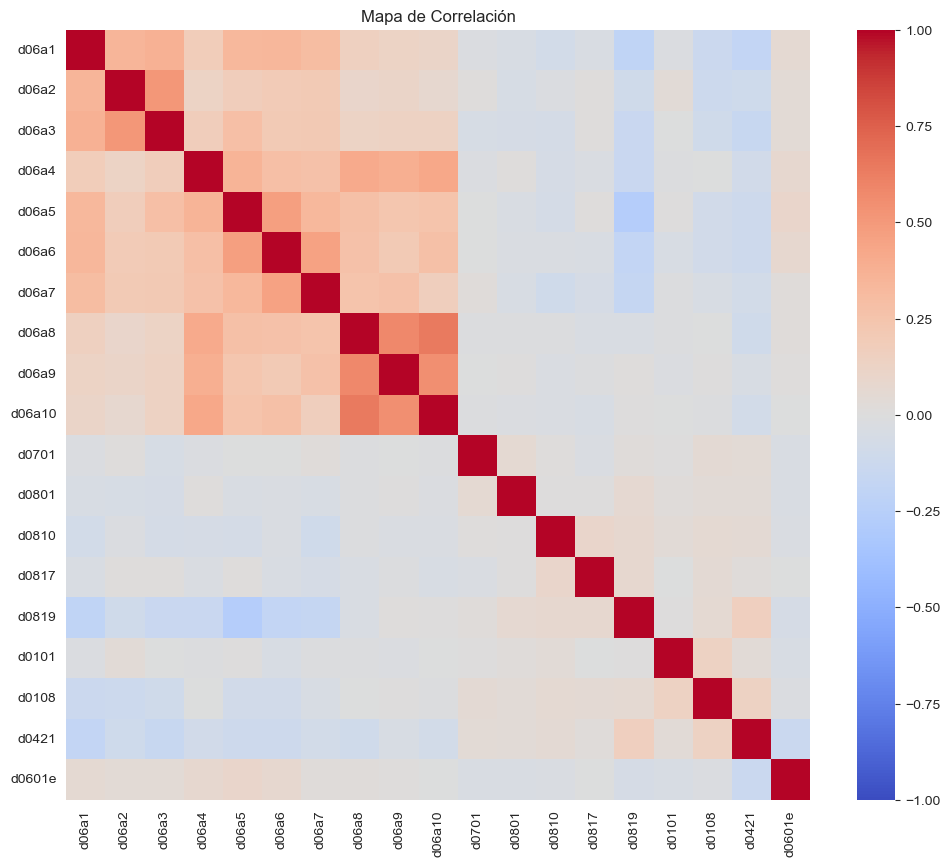

d06a8   d06a10    0.641805
d06a10  d06a8     0.641805
d06a8   d06a9     0.584085
d06a9   d06a8     0.584085
        d06a10    0.550175
d06a10  d06a9     0.550175
d06a3   d06a2     0.513320
d06a2   d06a3     0.513320
d06a5   d06a6     0.473803
d06a6   d06a5     0.473803
dtype: float64


In [7]:
# ==========================================
# 4.1 PREPARACIÓN DE DATOS // CORRELACIÓN Y D.R PREP.
# ==========================================

cols = ["edad", "sexo", "nivel_depresion"]
df_analisis = df_clean.drop(columns=cols)

plt.figure(figsize=(12, 10))
corr_matrix = df_analisis.corr()

sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Correlación")
plt.show()

corr = df_analisis.corr().abs()

top_corr = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))
        .unstack()
        .dropna()
        .sort_values(ascending=False)
)

print(top_corr.head(10))


C:\Users\ps222\anaconda3\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\ps222\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


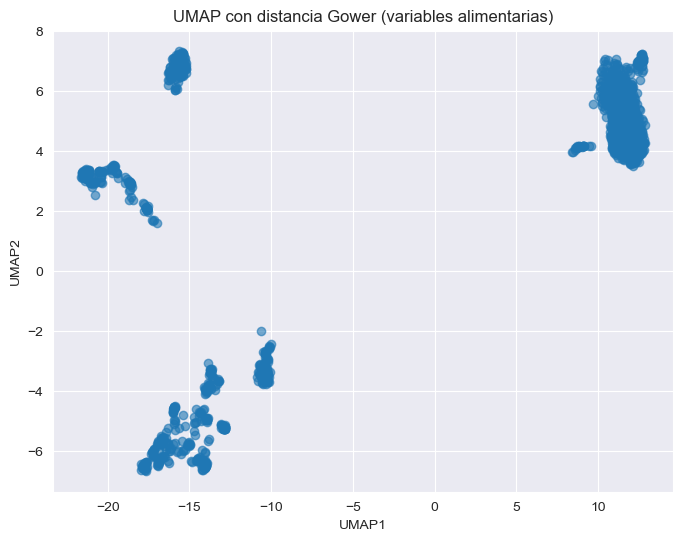

In [8]:
# ==========================================
# 5. UMAP - Reducción de dimensionalidad
# ==========================================

cols_alimentacion = ft_alimentarias
X = df_analisis[cols_alimentacion].copy()
# X = X.astype('object')
dist_matrix = gower.gower_matrix(X.astype('object'))

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed',
    random_state=42
)

reducer.fit(dist_matrix)
coords_umap = reducer.embedding_

plt.figure(figsize=(8,6))
plt.scatter(coords_umap[:,0], coords_umap[:,1], alpha=0.6)
plt.title("UMAP con distancia Gower (variables alimentarias)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


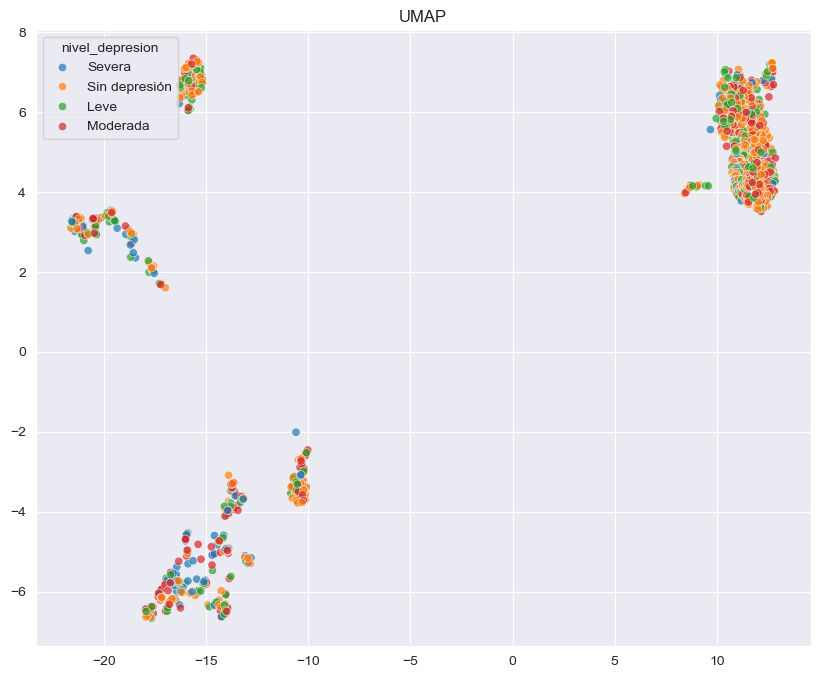

In [9]:
# Visualización del espacio UMAP coloreado por nivel de depresión

colores = df_clean['nivel_depresion']

plt.figure(figsize=(10, 8))
sns.scatterplot(x=coords_umap[:,0], y=coords_umap[:,1], hue=colores, alpha=0.7)
plt.title("UMAP")
plt.show()

In [10]:
print("Shape matriz distancias:", dist_matrix.shape)
print("Shape embedding:", coords_umap.shape)


Shape matriz distancias: (1592, 1592)
Shape embedding: (1592, 2)


In [11]:
pd.DataFrame(coords_umap, columns=["UMAP1", "UMAP2"]).var()

UMAP1    186.846527
UMAP2     21.976305
dtype: float32

In [12]:
# ==========================================
# CREAR DATAFRAME DE UMAP PARA USO EN EL ÁRBOL
# ==========================================

# coords_umap ya viene del UMAP anterior
df_umap = pd.DataFrame(coords_umap, columns=["UMAP1", "UMAP2"], index=df_clean.index)

print(df_umap.head())
print(df_umap.shape)


       UMAP1     UMAP2
0 -15.551192  6.966113
1 -21.517406  3.252255
2  11.138290  5.539479
3 -19.648222  3.542990
5  10.679192  5.396922
(1592, 2)


In [13]:
# Integración de variables reducidas (UMAP) y selección final de predictores

df_final = pd.concat([df_clean, df_umap], axis=1)
df_final = df_final.drop(columns=ft_alimentarias)

X = df_final.drop(columns=['nivel_depresion'])
y = df_final['nivel_depresion']

In [14]:
# Entrenamiento del arbol

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

arbol = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

arbol.fit(X_train, y_train)
y_pred = arbol.predict(X_test)


In [15]:
# Medir qué tan bien predice el árbol de decisión

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Matriz de confusión:\n", cm)

Accuracy: 0.38284518828451886
Matriz de confusión:
 [[ 28  22   6  72]
 [ 33  22   5  64]
 [ 13  17   6  14]
 [ 32  16   1 127]]


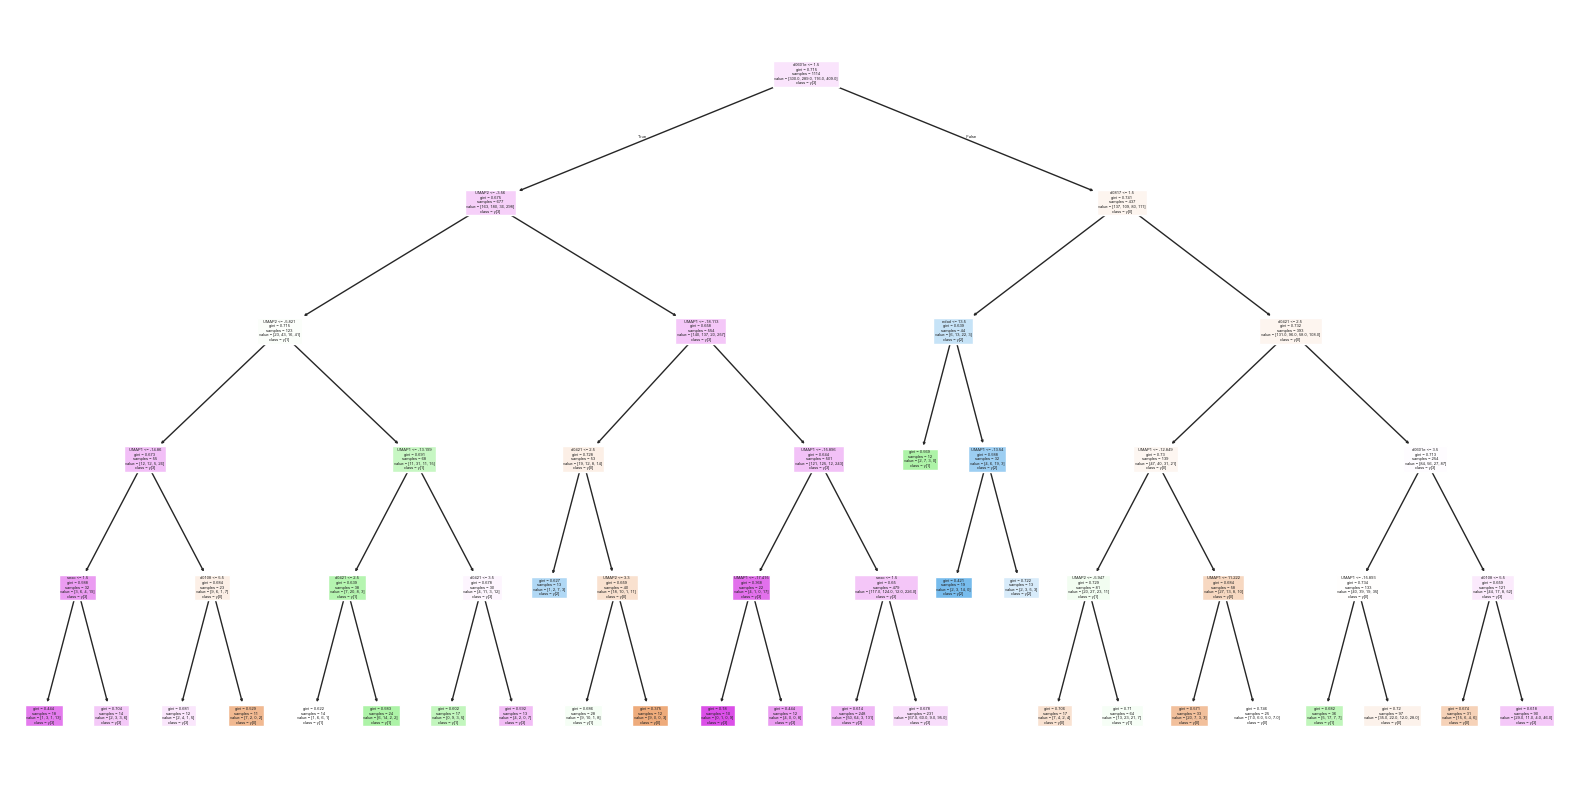

In [16]:
# Gráfico del árbol de decisión

plt.figure(figsize=(20,10))
tree.plot_tree(arbol, feature_names=X.columns, class_names=True, filled=True)
plt.show()

In [20]:
# ==========================================
# 6.A CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs CONSUMO DE ALCOHOL
# ==========================================

tabla_chi = pd.crosstab(df_clean['nivel_depresion'], df_clean['d0108'])

print("Tabla de contingencia: nivel_depresion x consumo de alcohol (d0108)")
print(tabla_chi)

# prueba de chi-cuadrada
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print("\n")
print("Resultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p:.5f}")

# Interpretación
if p < 0.05:
    print("\nConclusión: ")
    print(
        "Existe evidencia estadísticamente significativa de relación entre nivel de depresión y consumo de alcohol.")
else:
    print("\nConclusión: ")
    print("No se hay suficiente evidencia de que hay relación entre nivel de depresión y consumo de alcohol.")


Tabla de contingencia: nivel_depresion x consumo de alcohol (d0108)
d0108            1  2   3   4    5    6  9
nivel_depresion                           
Leve             1  7  19  51   91  258  1
Moderada         0  3  17  37  102  253  1
Severa           1  4  20  19   27   94  1
Sin depresión    0  5  19  48  129  382  2


Resultados prueba chi-cuadrada:
Chi2: 41.602
Grados de libertad: 18
p-valor: 0.00126

Conclusión: 
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y consumo de alcohol.


In [23]:
# ==========================================
# 6.B CHI-CUADRADA
# NIVEL DE DEPRESIÓN vs ABUSO SEXUAL
# ==========================================

# d0810 - abuso sexual

tabla_chi_abs_dep = pd.crosstab(df_clean['nivel_depresion'], df_clean['d0810'])

print("Tabla de contingencia: nivel_depresion x abuso sexual (d0810)")
print(tabla_chi_abs_dep)

# prueba de chi-cuadrada
chi2, p, dof, expected = chi2_contingency(tabla_chi_abs_dep)

print("\n")
print("Resultados prueba chi-cuadrada:")
print(f"Chi2: {chi2:.3f}")
print(f"Grados de libertad: {dof}")
print(f"p-valor: {p:.10f}")

# Interpretación
if p < 0.05:
    print("\nConclusión: ")
    print(
        "Existe evidencia estadísticamente significativa de relación entre nivel de depresión y abuso sexual.")
else:
    print("\nConclusión: ")
    print("No se hay suficiente evidencia de que hay relación entre nivel de depresión y abuso sexual.")


Tabla de contingencia: nivel_depresion x abuso sexual (d0810)
d0810             1  2    3  8  9
nivel_depresion                  
Leve             14  3  405  5  1
Moderada         17  2  387  4  3
Severa           19  4  137  5  1
Sin depresión     4  2  575  4  0


Resultados prueba chi-cuadrada:
Chi2: 67.802
Grados de libertad: 12
p-valor: 0.0000000008

Conclusión: 
Existe evidencia estadísticamente significativa de relación entre nivel de depresión y abuso sexual.
